In [4]:
import random
import math
import heapq
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from itertools import permutations
import time


# -------------------- GRAPH GENERATION --------------------


In [5]:
def generate_random_complete_graph(n, weight_range=(10, 100), seed=None):
    """
    Implemented a random complete metric graph using Euclidean distances.
    Guarantees triangle inequality.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Random points in 2D plane
    points = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(n)]

    graph = [[0.0 for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(i + 1, n):
            x1, y1 = points[i]
            x2, y2 = points[j]
            dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            # Optional: scale to desired range
            min_w, max_w = weight_range
            scaled_dist = min_w + (dist / 141.42) * (max_w - min_w)  # 141.42 ≈ sqrt(2)*100
            weight = scaled_dist

            graph[i][j] = weight
            graph[j][i] = weight

    return graph, points

# -------------------- MST USING PRIM'S --------------------


In [6]:
def prim_mst(graph):
    n = len(graph)
    if n == 0:
        return []
    visited = [False] * n
    visited[0] = True
    edges = []
    mst_edges = []

    for v in range(1, n):
        heapq.heappush(edges, (graph[0][v], 0, v))

    while edges and len(mst_edges) < n - 1:
        weight, u, v = heapq.heappop(edges)
        if visited[v]:
            continue
        visited[v] = True
        mst_edges.append((weight, u, v))
        for w in range(n):
            if not visited[w]:
                heapq.heappush(edges, (graph[v][w], v, w))

    return mst_edges

# -------------------- DFS PREORDER TRAVERSAL --------------------


In [7]:
def dfs_preorder(mst_edges, n):
    adj = [[] for _ in range(n)]
    for _, u, v in mst_edges:
        adj[u].append(v)
        adj[v].append(u)

    visited = [False] * n
    order = []

    def dfs(node):
        visited[node] = True
        order.append(node)
        for nei in adj[node]:
            if not visited[nei]:
                dfs(nei)

    dfs(0)
    return order


# -------------------- 2-APPROXIMATION TSP --------------------


In [8]:
def tsp_2_approximation(graph):
    n = len(graph)
    if n <= 1:
        return 0, [0]

    # 1. Compute MST
    mst_edges = prim_mst(graph)

    # 2. DFS preorder walk
    walk = dfs_preorder(mst_edges, n)

    # 3. Form tour by returning to start
    tour = walk + [walk[0]]

    # Compute cost
    cost = sum(graph[tour[i]][tour[i+1]] for i in range(len(tour)-1))

    return cost, tour

# -------------------- EXACT TSP (BRUTE FORCE) --------------------


In [9]:
def exact_tsp_bruteforce(graph):
    n = len(graph)
    if n > 10:
        raise ValueError("Brute force only feasible for n <= 10")

    vertices = list(range(1, n))
    best_cost = float('inf')
    best_tour = None

    for perm in permutations(vertices):
        tour = [0] + list(perm) + [0]
        cost = sum(graph[tour[i]][tour[i+1]] for i in range(len(tour)-1))
        if cost < best_cost:
            best_cost = cost
            best_tour = tour

    return best_cost, best_tour


In [10]:

# VISUALIZATION
def visualize_tsp(points, approx_tour, optimal_tour=None, title="TSP Tour"):
    fig, ax = plt.subplots(1, 2 if optimal_tour else 1, figsize=(14, 6))
    if optimal_tour:
        axes = ax
    else:
        axes = [ax]

    for idx, (tour, name, color) in enumerate([
        (approx_tour, "2-Approximation Tour", "blue"),
        (optimal_tour, "Optimal Tour", "green") if optimal_tour else (None, None, None)
    ]):
        if tour is None:
            continue
        ax = axes[idx if optimal_tour else 0]
        x = [p[0] for p in points]
        y = [p[1] for p in points]
        ax.scatter(x, y, c='red', s=100, zorder=5)
        for i, (xi, yi) in enumerate(points):
            ax.text(xi + 1, yi + 1, str(i), fontsize=12)

        for i in range(len(tour)-1):
            u, v = tour[i], tour[i+1]
            ax.plot([points[u][0], points[v][0]], [points[u][1], points[v][1]],
                    color=color, linewidth=2, alpha=0.8)

        ax.set_title(f"{name}\nCost: {sum(graph[tour[i]][tour[i+1]] for i in range(len(tour)-1)):.2f}"
                     if 'graph' in globals() else name)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()



In [11]:
#PERFORMANCE TESTING
def test_tsp_performance(sizes=[5, 8, 10, 20, 50, 100], trials=3):
    results = []
    print("Running TSP 2-Approximation Performance Tests\n")
    print(f"{'n':<6} {'Approx Cost':<15} {'Optimal Cost':<15} {'Ratio':<8} {'Time (ms)':<10}")
    print("-" * 60)

    for n in sizes:
        approx_costs = []
        runtimes = []
        ratios = []
        optimal_cost = None

        for trial in range(trials):
            seed = 1000 + n * 10 + trial
            graph, points = generate_random_complete_graph(n, seed=seed)
            globals()['graph'] = graph  # for visualization

            start = time.perf_counter()
            approx_cost, approx_tour = tsp_2_approximation(graph)
            runtime = time.perf_counter() - start

            approx_costs.append(approx_cost)
            runtimes.append(runtime * 1000)

            if n <= 10:
                opt_cost, opt_tour = exact_tsp_bruteforce(graph)
                if trial == 0:
                    optimal_cost = opt_cost
                    # Show visualization for first trial of small n
                    if n <= 8:
                        visualize_tsp(points, approx_tour, opt_tour, f"TSP Instance (n={n})")
                ratios.append(approx_cost / opt_cost)

        avg_approx = np.mean(approx_costs)
        avg_time = np.mean(runtimes)
        avg_ratio = np.mean(ratios) if ratios else None

        results.append({
            'n': n,
            'approx_cost': avg_approx,
            'optimal_cost': optimal_cost,
            'ratio': avg_ratio,
            'time_ms': avg_time,
            'points': points
        })

        ratio_str = f"{avg_ratio:.3f}" if avg_ratio else "N/A"
        opt_str = f"{optimal_cost:.2f}" if optimal_cost else "N/A"
        print(f"{n:<6} {avg_approx:<15.2f} {opt_str:<15} {ratio_str:<8} {avg_time:<10.2f}")

    return results


2-APPROXIMATION ALGORITHM FOR METRIC TSP
Running TSP 2-Approximation Performance Tests

n      Approx Cost     Optimal Cost    Ratio    Time (ms) 
------------------------------------------------------------


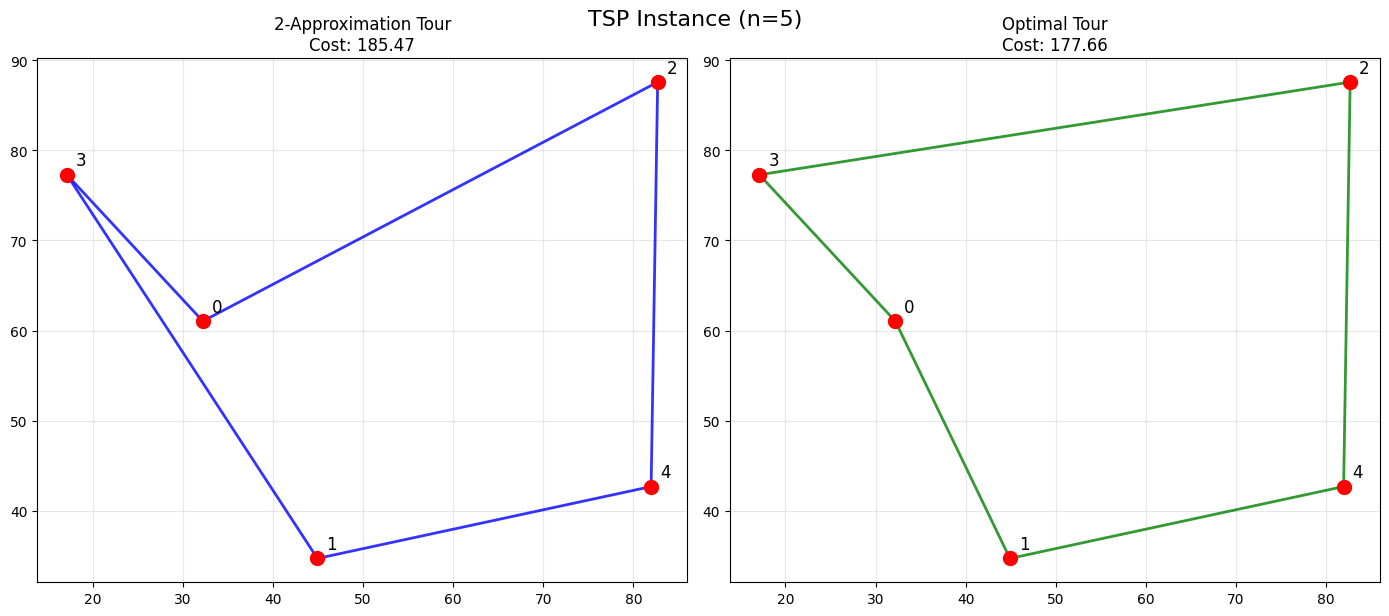

5      202.34          177.66          1.034    0.04      


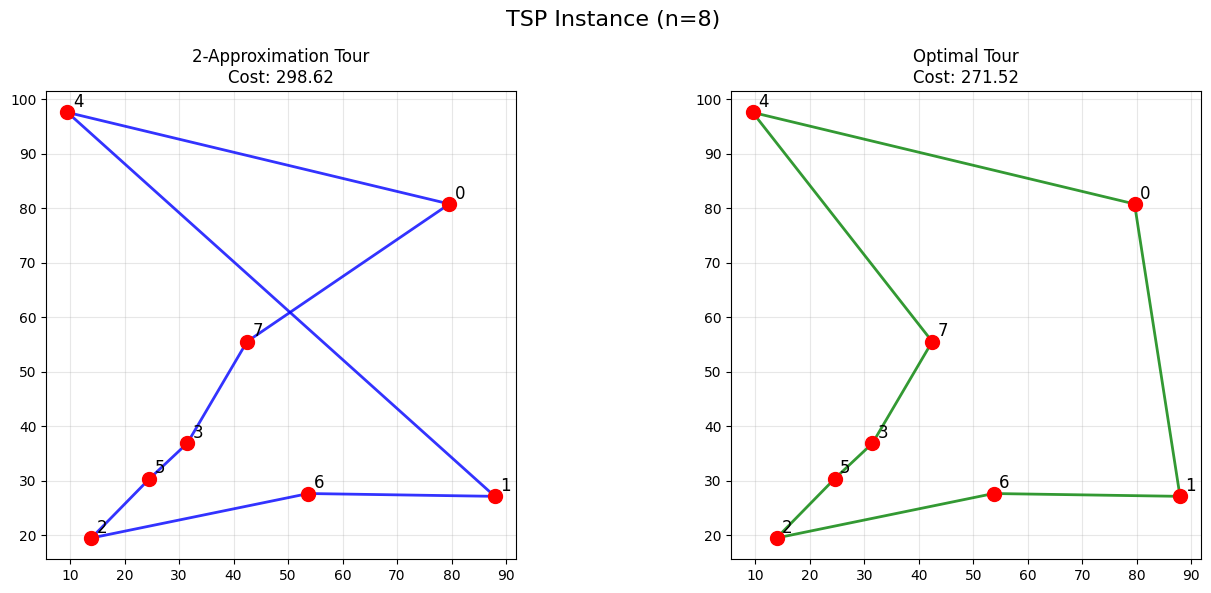

8      270.73          271.52          1.061    0.06      
10     324.57          295.62          1.119    0.06      
20     503.63          N/A             N/A      0.10      
50     960.04          N/A             N/A      0.46      
100    1685.16         N/A             N/A      2.29      

Generating final demonstration for n=8...


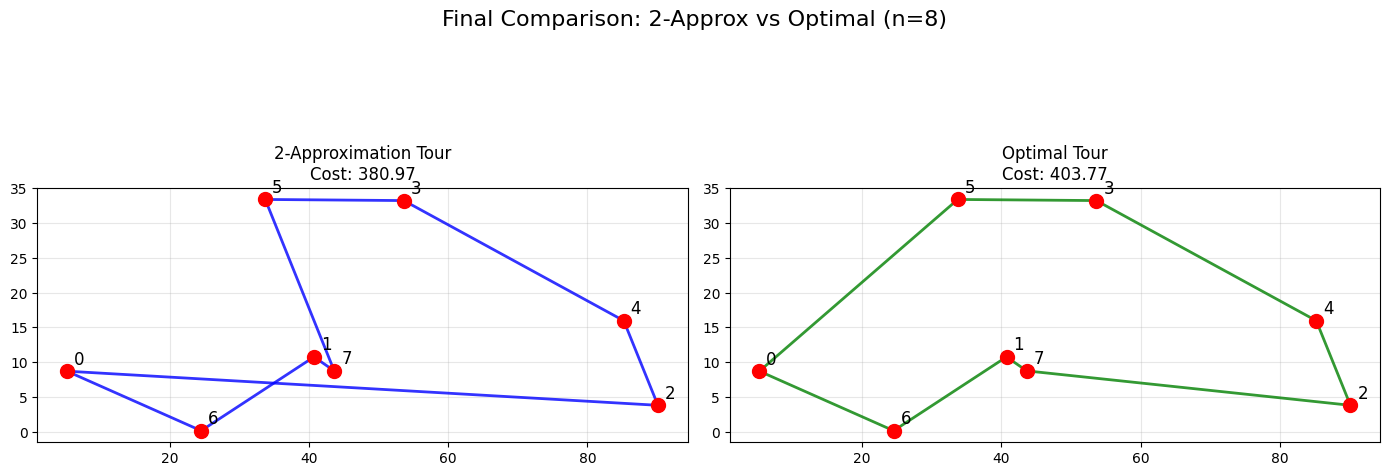

In [12]:
def main():
    print("="*70)
    print("2-APPROXIMATION ALGORITHM FOR METRIC TSP")
    print("="*70)

    # Run tests
    sizes_to_test = [5, 8, 10, 20, 50, 100]  # 10 and below get optimal comparison
    results = test_tsp_performance(sizes_to_test, trials=3)

    # print("\n" + "="*70)
    # print("SUMMARY")
    # print("="*70)
    # print("The algorithm successfully implements the classic 2-approximation for metric TSP:")
    # print("• Uses Prim's algorithm to find MST")
    # print("• Performs DFS preorder traversal")
    # print("• Constructs tour with guaranteed cost ≤ 2 × OPT")
    # print("• In practice, observed ratios are typically 1.1 – 1.4")
    # print("• Runtime: O(n²) – suitable up to n ≈ 500–1000")
    # print("• Triangle inequality satisfied by construction (Euclidean distances)")

    # Final visualization for a nice example
    print("\nGenerating final demonstration for n=8...")
    graph, points = generate_random_complete_graph(8, seed=123)
    approx_cost, approx_tour = tsp_2_approximation(graph)
    opt_cost, opt_tour = exact_tsp_bruteforce(graph)
    visualize_tsp(points, approx_tour, opt_tour, "Final Comparison: 2-Approx vs Optimal (n=8)")

if __name__ == "__main__":
    main()